In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
# import numpy as np
import mplhep as hep
import numpy as np
import warnings

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
# for x in range(len(signals_all)):
#     # if x == 0:
#     print("'" + signals_all[x] + "',")
    

In [3]:
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
    "DYJetsToMuMu_M50",
     ]
TT = [ 
    "TTJets",
     ]

bgs=  TT + QCD + DY


def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist

def plot_signal_and_percentage_grid_all(data):
    # Collect all (bound_mass, zd_mass) pairs
    combos = []
    for mass, zd_dict in data.items():
        for zd in zd_dict.keys():
            combos.append((mass, zd))
    combos = sorted(combos, key=lambda x: (x[0], x[1]))  # sort nicely

    # Collect all Lxy values (y-axis)
    lab_vals = sorted(set(
        lab for mass in data for zd in data[mass] for lab in data[mass][zd].keys()
    ))
    # Initialize grids
    z_yield = np.full((len(lab_vals), len(combos)), np.nan)
    z_percent = np.full((len(lab_vals), len(combos)), np.nan)

    # Fill grids
    for j, (mass, zd) in enumerate(combos):
        for i, lab in enumerate(lab_vals):
            values = data[mass][zd].get(lab, [np.nan, np.nan])
            z_yield[i, j] = values[0]
            z_percent[i, j] = values[1]

    # X-axis labels like "100/0.25"
    x_labels = [f"{m}/{zd}" for m, zd in combos]


    fig, axs = plt.subplots(2, 1, figsize=(48, 30), constrained_layout=True)

    # --- Plot yield ---
    im1 = axs[0].imshow(
        z_yield,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=5,
        # norm=LogNorm(vmin=1e-2, vmax=1e2),
        aspect='auto'
    )
    axs[0].set_xticks(np.arange(len(combos)))
    axs[0].set_xticklabels(x_labels, rotation=90)
    axs[0].set_yticks(np.arange(len(lab_vals)))
    axs[0].set_yticklabels(lab_vals)
    axs[0].set_title(r"$S/\sqrt{B}$")
    axs[0].set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    axs[0].set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im1, ax=axs[0])

    # --- Plot percentage ---
    im2 = axs[1].imshow(
        z_percent,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=0.05,
        aspect='auto'
    )
    axs[1].set_xticks(np.arange(len(combos)))
    axs[1].set_xticklabels(x_labels, rotation=90)
    axs[1].set_yticks(np.arange(len(lab_vals)))
    axs[1].set_yticklabels(lab_vals)
    axs[1].set_title("Threshold")
    axs[1].set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    axs[1].set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im2, ax=axs[1])

    plt.show()
    plt.close()


In [ ]:
output_signal =coffea.util.load("output_signalbase_ljObjCut_ljIso_2lj.coffea")
thresholds = np.arange(0, 20, 1)
print("thresholds", thresholds)
histogram_name = "pf_mu_lj_pfMuon_max_trkNumTrkLayers"
channel_name = "base_ljObjCut_ljIso_2lj"
signal_pass = {}
for s in signals_all:
    # print(s)
    histogram =  output_signal["out"][s]["hists"][histogram_name][channel_name,:]
    values = histogram.values()
    values_flow = histogram.values(flow=True)
    overflow = values_flow[-1]
    underflow = values_flow[0]
    bin_edges = histogram.axes[0].edges
    # print(values.sum() + overflow)
    n_events = []
    for threshold in thresholds:
        idx = np.searchsorted(bin_edges, threshold, side="right") -1 
        idx = max(idx, 0)  # avoid negative index 
        
        n_events_thres = values[:idx + 1].sum() + underflow
        # print("thre", repr(threshold), idx, bin_edges[idx  ],n_events_thres)
        n_events.append(n_events_thres)
    # print(n_events)
    signal_pass[s] = n_events
    # print(signal_pass)
##Sum of background histograms:
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 
# print("Total background", total_bg)
for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
# print(n_events_bg)

print("background stayed with threshold", n_events_bg)
##Now find the the values that passes the threshold
fraction = np.array(n_events_bg)/total_bg
plt.figure(figsize=(12, 10))
plt.plot(thresholds, fraction, marker ="o", linestyle="-",)
plt.ylabel("Fraction of Backgrond")
plt.xlabel(histogram_name)
hep.cms.label()
plt.show()
plt.close()




## Finding S over Root for the 2 pf Case:
S_over_rootB={}
for x in signals_all:
    s = np.array(signal_pass[x])
    b = np.array(n_events_bg)

    # Check for zeros in b
    if np.any(b == 0):
        # warnings.warn(f"Background count has zeros for signal {x}. Replacing zeros with a tiny value to avoid division by zero.")
        b = np.where(b == 0, 1e-10, b)  # replace zeros with a small number

    s_over_rootb = s / np.sqrt(b)
    S_over_rootB[x] = s_over_rootb

# Assume you already have:
# thresholds = np.arange(0.0, 0.05, 0.001)
# S_over_rootB = {signal_name: array_of_values}

best_SoverB = {}  # to store best (max value, threshold) for each signal
best_thresholds_list = []
for signal_name, s_over_rootb in S_over_rootB.items():
    # print(s_over_rootb)
    max_idx = np.argmax(s_over_rootb)
    # print(max_idx)
    max_val = s_over_rootb[max_idx]
    best_thresh = thresholds[max_idx]
    best_thresholds_list.append(best_thresh)
    best_SoverB[signal_name] = {
        "max_SoverRootB": max_val,
        "threshold": best_thresh
    }



# from collections import Counter
# # Count frequency
# freq = Counter(best_thresholds_list)

# # Print result
# for value, count in freq.items():
#     print(f"{value:.3f}: {count}")

# print(dict_values_lxy)
# # Print results
for sig, result in best_SoverB.items():
    print(f"{sig}: max S/√B = {result['max_SoverRootB']:.3f} at threshold = {result['threshold']:.4f}")




thresholds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
background stayed with threshold [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09326960087336486, 241.78110786582312, 250.73145608467755, 278.41264172765557, 523.0574974326825, 791.0423616458377, 1377.9490702824558, 1546.7543035173362, 1653.9369198673762, 1662.9210532173954, 1666.1567620123976, 1666.1567620123976]


thresholds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
background stayed with threshold [0.029030337094951886, 124.41707943462609, 135.85658585300786, 335.3153216224212, 1241.4364960139956, 1482.6661054834262, 1608.2398511575807, 1664.7353237899226, 1666.155621635753, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978, 1666.1567620123978]


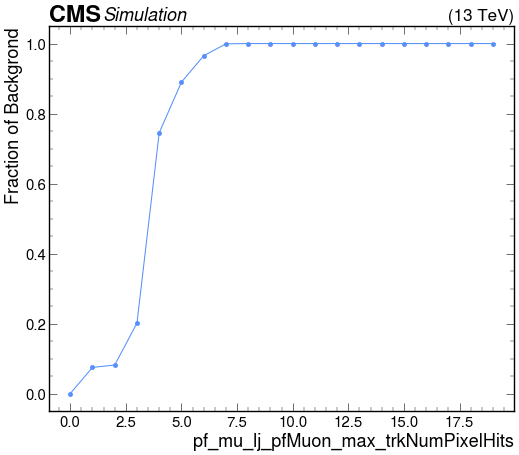

2Mu2E_100GeV_0p25GeV_0p02mm: max S/√B = 0.072 at threshold = 9.0000
2Mu2E_100GeV_0p25GeV_0p2mm: max S/√B = 0.580 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_2p0mm: max S/√B = 3.948 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_10p0mm: max S/√B = 0.956 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_20p0mm: max S/√B = 0.314 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_0p096mm: max S/√B = 0.047 at threshold = 9.0000
2Mu2E_100GeV_1p2GeV_0p96mm: max S/√B = 0.300 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_9p6mm: max S/√B = 2.300 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_48p0mm: max S/√B = 0.654 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_96p0mm: max S/√B = 0.243 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_0p4mm: max S/√B = 0.045 at threshold = 9.0000
2Mu2E_100GeV_5p0GeV_4p0mm: max S/√B = 0.258 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_40p0mm: max S/√B = 1.501 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_200mm: max S/√B = 0.378 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_400mm: max S/√B = 0.109 at threshold = 0.0

In [10]:
output_signal =coffea.util.load("output_signalbase_ljObjCut_ljIso_2lj.coffea")
thresholds = np.arange(0, 20, 1)
print("thresholds", thresholds)
histogram_name = "pf_mu_lj_pfMuon_max_trkNumPixelHits"
channel_name = "base_ljObjCut_ljIso_2lj"
signal_pass = {}
for s in signals_all:
    # print(s)
    histogram =  output_signal["out"][s]["hists"][histogram_name][channel_name,:]
    values = histogram.values()
    values_flow = histogram.values(flow=True)
    overflow = values_flow[-1]
    underflow = values_flow[0]
    bin_edges = histogram.axes[0].edges
    # print(values.sum() + overflow)
    n_events = []
    for threshold in thresholds:
        idx = np.searchsorted(bin_edges, threshold, side="right") -1 
        idx = max(idx, 0)  # avoid negative index 
        
        n_events_thres = values[:idx + 1].sum() + underflow
        # print("thre", repr(threshold), idx, bin_edges[idx  ],n_events_thres)
        n_events.append(n_events_thres)
    # print(n_events)
    signal_pass[s] = n_events
    # print(signal_pass)
##Sum of background histograms:
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 
# print("Total background", total_bg)
for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
# print(n_events_bg)

print("background stayed with threshold", n_events_bg)
##Now find the the values that passes the threshold
fraction = np.array(n_events_bg)/total_bg
plt.figure(figsize=(12, 10))
plt.plot(thresholds, fraction, marker ="o", linestyle="-",)
plt.ylabel("Fraction of Backgrond")
plt.xlabel(histogram_name)
hep.cms.label()
plt.show()
plt.close()




## Finding S over Root for the 2 pf Case:
S_over_rootB={}
for x in signals_all:
    s = np.array(signal_pass[x])
    b = np.array(n_events_bg)

    # Check for zeros in b
    if np.any(b == 0):
        # warnings.warn(f"Background count has zeros for signal {x}. Replacing zeros with a tiny value to avoid division by zero.")
        b = np.where(b == 0, 1e-10, b)  # replace zeros with a small number

    s_over_rootb = s / np.sqrt(b)
    S_over_rootB[x] = s_over_rootb

# Assume you already have:
# thresholds = np.arange(0.0, 0.05, 0.001)
# S_over_rootB = {signal_name: array_of_values}

best_SoverB = {}  # to store best (max value, threshold) for each signal
best_thresholds_list = []
for signal_name, s_over_rootb in S_over_rootB.items():
    # print(s_over_rootb)
    max_idx = np.argmax(s_over_rootb)
    # print(max_idx)
    max_val = s_over_rootb[max_idx]
    best_thresh = thresholds[max_idx]
    best_thresholds_list.append(best_thresh)
    best_SoverB[signal_name] = {
        "max_SoverRootB": max_val,
        "threshold": best_thresh
    }



# from collections import Counter
# # Count frequency
# freq = Counter(best_thresholds_list)

# # Print result
# for value, count in freq.items():
#     print(f"{value:.3f}: {count}")

# print(dict_values_lxy)
# # Print results
for sig, result in best_SoverB.items():
    print(f"{sig}: max S/√B = {result['max_SoverRootB']:.3f} at threshold = {result['threshold']:.4f}")




thresholds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
background stayed with threshold [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011403766447566285, 0.0944099775181215, 241.9125308169495, 303.2589855263798, 396.936440831516, 671.6207734428012, 959.2011614147593, 1572.8211824604573, 1757.9041724384424, 1875.5315660023082, 1887.7890405766066, 1891.0258897482536, 1891.0258897482536]


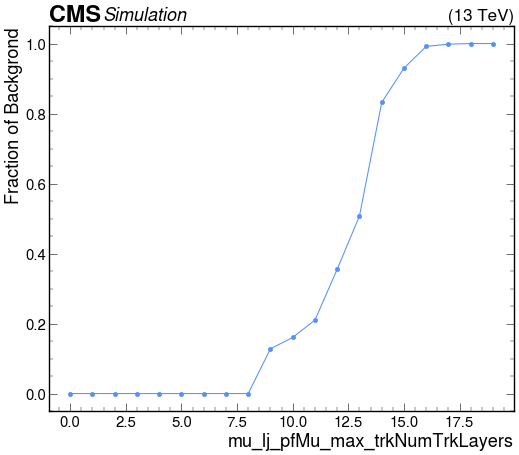

2Mu2E_100GeV_0p25GeV_0p02mm: max S/√B = 95.180 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_0p2mm: max S/√B = 259.839 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_2p0mm: max S/√B = 16831.358 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_10p0mm: max S/√B = 9419.009 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_20p0mm: max S/√B = 3537.742 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_0p096mm: max S/√B = 0.044 at threshold = 18.0000
2Mu2E_100GeV_1p2GeV_0p96mm: max S/√B = 60.174 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_9p6mm: max S/√B = 8129.571 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_48p0mm: max S/√B = 5740.482 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_96p0mm: max S/√B = 1832.702 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_0p4mm: max S/√B = 0.043 at threshold = 17.0000
2Mu2E_100GeV_5p0GeV_4p0mm: max S/√B = 0.038 at threshold = 18.0000
2Mu2E_100GeV_5p0GeV_40p0mm: max S/√B = 5012.641 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_200mm: max S/√B = 3719.703 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_400mm: max

In [9]:
output_signal =coffea.util.load("output_signalbase_ljObjCut_ljIso_2lj.coffea")
thresholds = np.arange(0, 20, 1)
print("thresholds", thresholds)
histogram_name = "mu_lj_pfMu_max_trkNumTrkLayers"
channel_name = "base_ljObjCut_ljIso_2lj"
signal_pass = {}
for s in signals_all:
    # print(s)
    histogram =  output_signal["out"][s]["hists"][histogram_name][channel_name,:]
    values = histogram.values()
    values_flow = histogram.values(flow=True)
    overflow = values_flow[-1]
    underflow = values_flow[0]
    bin_edges = histogram.axes[0].edges
    # print(values.sum() + overflow)
    n_events = []
    for threshold in thresholds:
        idx = np.searchsorted(bin_edges, threshold, side="right") -1 
        idx = max(idx, 0)  # avoid negative index 
        
        n_events_thres = values[:idx + 1].sum() + underflow
        # print("thre", repr(threshold), idx, bin_edges[idx  ],n_events_thres)
        n_events.append(n_events_thres)
    # print(n_events)
    signal_pass[s] = n_events
    # print(signal_pass)
##Sum of background histograms:
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 
# print("Total background", total_bg)
for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
# print(n_events_bg)

print("background stayed with threshold", n_events_bg)
##Now find the the values that passes the threshold
fraction = np.array(n_events_bg)/total_bg
plt.figure(figsize=(12, 10))
plt.plot(thresholds, fraction, marker ="o", linestyle="-",)
plt.ylabel("Fraction of Backgrond")
plt.xlabel(histogram_name)
hep.cms.label()
plt.show()
plt.close()




## Finding S over Root for the 2 pf Case:
S_over_rootB={}
for x in signals_all:
    s = np.array(signal_pass[x])
    b = np.array(n_events_bg)

    # Check for zeros in b
    if np.any(b == 0):
        # warnings.warn(f"Background count has zeros for signal {x}. Replacing zeros with a tiny value to avoid division by zero.")
        b = np.where(b == 0, 1e-10, b)  # replace zeros with a small number

    s_over_rootb = s / np.sqrt(b)
    S_over_rootB[x] = s_over_rootb
    # print(x, s_over_rootb)

# Assume you already have:
# thresholds = np.arange(0.0, 0.05, 0.001)
# S_over_rootB = {signal_name: array_of_values}

best_SoverB = {}  # to store best (max value, threshold) for each signal
best_thresholds_list = []
for signal_name, s_over_rootb in S_over_rootB.items():
    # print(s_over_rootb)
    max_idx = np.argmax(s_over_rootb)
    # print(max_idx)
    max_val = s_over_rootb[max_idx]
    best_thresh = thresholds[max_idx]
    best_thresholds_list.append(best_thresh)
    best_SoverB[signal_name] = {
        "max_SoverRootB": max_val,
        "threshold": best_thresh
    }



# from collections import Counter
# # Count frequency
# freq = Counter(best_thresholds_list)

# # Print result
# for value, count in freq.items():
#     print(f"{value:.3f}: {count}")

# print(dict_values_lxy)
# # Print results
for sig, result in best_SoverB.items():
    print(f"{sig}: max S/√B = {result['max_SoverRootB']:.3f} at threshold = {result['threshold']:.4f}")




thresholds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
background stayed with threshold [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011403766447566285, 0.0011403766447566285, 0.1325633277711264, 52.52866981834698, 118.52493948050517, 148.5666971400529, 168.16222089885574, 194.8755333079356, 211.15329005104036, 221.59806726486622, 224.87140848914538, 224.87254886579015, 224.87254886579015]


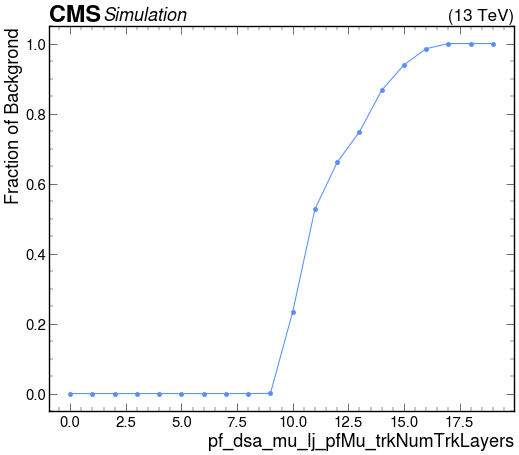

2Mu2E_100GeV_0p25GeV_0p02mm: max S/√B = 47.590 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_0p2mm: max S/√B = 155.903 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_2p0mm: max S/√B = 11204.306 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_10p0mm: max S/√B = 7206.109 at threshold = 6.0000
2Mu2E_100GeV_0p25GeV_20p0mm: max S/√B = 3086.116 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_0p096mm: max S/√B = 0.001 at threshold = 14.0000
2Mu2E_100GeV_1p2GeV_0p96mm: max S/√B = 60.174 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_9p6mm: max S/√B = 4550.133 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_48p0mm: max S/√B = 4254.710 at threshold = 6.0000
2Mu2E_100GeV_1p2GeV_96p0mm: max S/√B = 1350.412 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_0p4mm: max S/√B = 619.551 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_4p0mm: max S/√B = 680.913 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_40p0mm: max S/√B = 4187.776 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_200mm: max S/√B = 3362.040 at threshold = 6.0000
2Mu2E_100GeV_5p0GeV_400mm: m

In [7]:
output_signal =coffea.util.load("output_signalbase_ljObjCut_ljIso_2lj.coffea")
thresholds = np.arange(0, 20, 1)
print("thresholds", thresholds)
histogram_name = "pf_dsa_mu_lj_pfMu_trkNumTrkLayers"
channel_name = "base_ljObjCut_ljIso_2lj"
signal_pass = {}
for s in signals_all:
    # print(s)
    histogram =  output_signal["out"][s]["hists"][histogram_name][channel_name,:]
    values = histogram.values()
    values_flow = histogram.values(flow=True)
    overflow = values_flow[-1]
    underflow = values_flow[0]
    bin_edges = histogram.axes[0].edges
    # print(values.sum() + overflow)
    n_events = []
    for threshold in thresholds:
        idx = np.searchsorted(bin_edges, threshold, side="right") -1 
        idx = max(idx, 0)  # avoid negative index 
        
        n_events_thres = values[:idx + 1].sum() + underflow
        # print("thre", repr(threshold), idx, bin_edges[idx  ],n_events_thres)
        n_events.append(n_events_thres)
    # print(n_events)
    signal_pass[s] = n_events
    # print(signal_pass)
##Sum of background histograms:
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 
# print("Total background", total_bg)
for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
# print(n_events_bg)

print("background stayed with threshold", n_events_bg)
##Now find the the values that passes the threshold
fraction = np.array(n_events_bg)/total_bg
plt.figure(figsize=(12, 10))
plt.plot(thresholds, fraction, marker ="o", linestyle="-",)
plt.ylabel("Fraction of Backgrond")
plt.xlabel(histogram_name)
hep.cms.label()
plt.show()
plt.close()




## Finding S over Root for the 2 pf Case:
S_over_rootB={}
for x in signals_all:
    s = np.array(signal_pass[x])
    b = np.array(n_events_bg)

    # Check for zeros in b
    if np.any(b == 0):
        # warnings.warn(f"Background count has zeros for signal {x}. Replacing zeros with a tiny value to avoid division by zero.")
        b = np.where(b == 0, 1e-10, b)  # replace zeros with a small number

    s_over_rootb = s / np.sqrt(b)
    S_over_rootB[x] = s_over_rootb

# Assume you already have:
# thresholds = np.arange(0.0, 0.05, 0.001)
# S_over_rootB = {signal_name: array_of_values}

best_SoverB = {}  # to store best (max value, threshold) for each signal
best_thresholds_list = []
for signal_name, s_over_rootb in S_over_rootB.items():
    # print(s_over_rootb)
    max_idx = np.argmax(s_over_rootb)
    # print(max_idx)
    max_val = s_over_rootb[max_idx]
    best_thresh = thresholds[max_idx]
    best_thresholds_list.append(best_thresh)
    best_SoverB[signal_name] = {
        "max_SoverRootB": max_val,
        "threshold": best_thresh
    }



# from collections import Counter
# # Count frequency
# freq = Counter(best_thresholds_list)

# # Print result
# for value, count in freq.items():
#     print(f"{value:.3f}: {count}")

# print(dict_values_lxy)
# # Print results
for sig, result in best_SoverB.items():
    print(f"{sig}: max S/√B = {result['max_SoverRootB']:.3f} at threshold = {result['threshold']:.4f}")




thresholds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
background stayed with threshold [0.0, 0.03473222031873503, 4.080202985307611, 86.36612962913085, 194.81167221582925, 205.31004713195867, 221.5695578487473, 221.62087479776136, 221.6334189408537, 224.87254886579015, 224.87254886579015, 224.87254886579015, 224.87254886579015, 224.87254886579015, 224.87254886579015, 224.87254886579012, 224.87254886579012, 224.87254886579012, 224.87254886579012, 224.87254886579012]


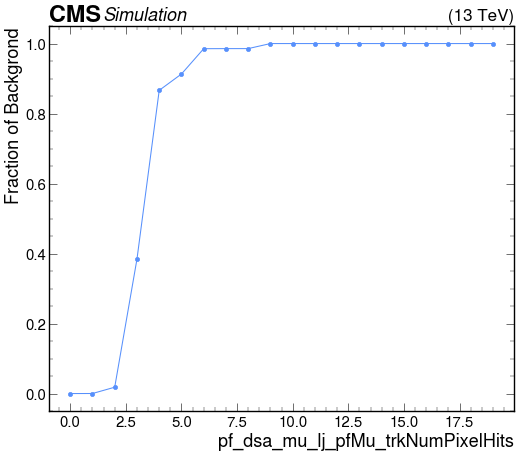

2Mu2E_100GeV_0p25GeV_0p02mm: max S/√B = 95.180 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_0p2mm: max S/√B = 1559.034 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_2p0mm: max S/√B = 29579.369 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_10p0mm: max S/√B = 10951.017 at threshold = 0.0000
2Mu2E_100GeV_0p25GeV_20p0mm: max S/√B = 4892.623 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_0p096mm: max S/√B = 0.001 at threshold = 7.0000
2Mu2E_100GeV_1p2GeV_0p96mm: max S/√B = 601.736 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_9p6mm: max S/√B = 9646.282 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_48p0mm: max S/√B = 4187.175 at threshold = 0.0000
2Mu2E_100GeV_1p2GeV_96p0mm: max S/√B = 1929.160 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_0p4mm: max S/√B = 68.839 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_4p0mm: max S/√B = 866.617 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_40p0mm: max S/√B = 8121.748 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_200mm: max S/√B = 3290.507 at threshold = 0.0000
2Mu2E_100GeV_5p0GeV_400mm: 

In [8]:
output_signal =coffea.util.load("output_signalbase_ljObjCut_ljIso_2lj.coffea")
thresholds = np.arange(0, 20, 1)
print("thresholds", thresholds)
histogram_name = "pf_dsa_mu_lj_pfMu_trkNumPixelHits"
channel_name = "base_ljObjCut_ljIso_2lj"
signal_pass = {}
for s in signals_all:
    # print(s)
    histogram =  output_signal["out"][s]["hists"][histogram_name][channel_name,:]
    values = histogram.values()
    values_flow = histogram.values(flow=True)
    overflow = values_flow[-1]
    underflow = values_flow[0]
    bin_edges = histogram.axes[0].edges
    # print(values.sum() + overflow)
    n_events = []
    for threshold in thresholds:
        idx = np.searchsorted(bin_edges, threshold, side="right") -1 
        idx = max(idx, 0)  # avoid negative index 
        
        n_events_thres = values[:idx + 1].sum() + underflow
        # print("thre", repr(threshold), idx, bin_edges[idx  ],n_events_thres)
        n_events.append(n_events_thres)
    # print(n_events)
    signal_pass[s] = n_events
    # print(signal_pass)
##Sum of background histograms:
sum_bg = sum_bgs_hist(bgs, histogram_name, channel_name)
values_bg = sum_bg.values()
overflow_bg= sum_bg.values(flow=True)[-1]
underflow_bg= sum_bg.values(flow=True)[0]
n_events_bg =[]
bin_edges = sum_bg.axes[0].edges
total_bg = values_bg.sum() + overflow_bg + underflow_bg 
# print("Total background", total_bg)
for t in thresholds:
    idx = np.searchsorted(bin_edges, t, side="right") -1 
    idx = max(idx, 0)  # avoid negative index 
    n_events_bg_thres = values_bg[:idx + 1].sum() + underflow_bg
    # print("thre", repr(t), idx, bin_edges[idx  ],n_events_bg_thres)
    n_events_bg.append(n_events_bg_thres)
# print(n_events_bg)

print("background stayed with threshold", n_events_bg)
##Now find the the values that passes the threshold
fraction = np.array(n_events_bg)/total_bg
plt.figure(figsize=(12, 10))
plt.plot(thresholds, fraction, marker ="o", linestyle="-",)
plt.ylabel("Fraction of Backgrond")
plt.xlabel(histogram_name)
hep.cms.label()
plt.show()
plt.close()




## Finding S over Root for the 2 pf Case:
S_over_rootB={}
for x in signals_all:
    s = np.array(signal_pass[x])
    b = np.array(n_events_bg)

    # Check for zeros in b
    if np.any(b == 0):
        # warnings.warn(f"Background count has zeros for signal {x}. Replacing zeros with a tiny value to avoid division by zero.")
        b = np.where(b == 0, 1e-10, b)  # replace zeros with a small number

    s_over_rootb = s / np.sqrt(b)
    S_over_rootB[x] = s_over_rootb

# Assume you already have:
# thresholds = np.arange(0.0, 0.05, 0.001)
# S_over_rootB = {signal_name: array_of_values}

best_SoverB = {}  # to store best (max value, threshold) for each signal
best_thresholds_list = []
for signal_name, s_over_rootb in S_over_rootB.items():
    # print(s_over_rootb)
    max_idx = np.argmax(s_over_rootb)
    # print(max_idx)
    max_val = s_over_rootb[max_idx]
    best_thresh = thresholds[max_idx]
    best_thresholds_list.append(best_thresh)
    best_SoverB[signal_name] = {
        "max_SoverRootB": max_val,
        "threshold": best_thresh
    }



# from collections import Counter
# # Count frequency
# freq = Counter(best_thresholds_list)

# # Print result
# for value, count in freq.items():
#     print(f"{value:.3f}: {count}")

# print(dict_values_lxy)
# # Print results
for sig, result in best_SoverB.items():
    print(f"{sig}: max S/√B = {result['max_SoverRootB']:.3f} at threshold = {result['threshold']:.4f}")


